# Challenge : Prédire la tendance de la production de pétrole brut. 

## 1. Description des données

Les ensembles de données fournis contiennent des données sur le pétrole brut, y compris lease condensate - à l'exclusion des NGL (hydrocarbures liquides ou liquides). Toutes les données fournies sont des Open Data provenant de "The Joint Organizations Data Initiative (JODI)".   
Les données historiques couvrent les déclarations de tous les producteurs de pétrole brut du monde entier pour la période allant de janvier 2002 à août 2016. 
Chaque ligne est définie par son identifiant unique et contient des informations historiques concernant le secteur du pétrole brut d'un pays au cours de la dernière année. Certaines de ces caractéristiques contiennent des informations agrégées sur le secteur mondial du pétrole brut. 
 
La séparation entre le training et le test a été faite, de sorte que les données les plus récentes ont été mises dans le jeu de données de test. Les pays ont été anonymisés dans les données. L'objectif est d'estimer pour l'ensemble des données de test la probabilité de l'augmentation de la production de pétrole brut pour le trimestre suivant et cela pour chaque ligne. 
 
Les fichiers Train et Test contiennent les fonctions suivantes : 

- ID : ID de la ligne qui contient 12 mois de données d'un pays donné et d'autres informations détaillées ci-dessus. 
- month (mois) : Indice de mois. Il n'y a aucune indication concernant l'année de la collecte des données. 
- country (pays) : Indice des pays. Comme indiqué ci-dessus, les pays ont été anonymisés. 
 
Et les caractéristiques qui sont données pour chaque mois de l'année précédente : 
 
- closing stocks (stocks de fermeture) (kmt) : représente le niveau de stock primaire à la fin du mois dans les territoires nationaux; Comprend les stocks détenus par les importateurs, les raffineurs, les organisations boursières et les gouvernements en milliers de tonnes. 
- Exports (exportations) (kmt) / Imports (Importations) (kmt) : Quantité de pétrole brut ayant traversé physiquement les frontières internationales, à l'exclusion du commerce de transit, des bunkers internationaux de la marine et de l'aviation en milliers de tonnes métriques. 
- refinery intake (consommation de raffinerie) (kmt) : quantité totale de pétrole observée pour entrer dans le processus de raffinage en milliers de tonnes. 
- WTI : West Texas Intermediate Price. Cette valeur correspond au cours de clôture du dernier jour ouvrable du mois en USD. 
- SumConsing stocks (kmt), SumExports (kmt), SumImports (kmt), SumProduction (kmt) et SumRefinery intake (kmt) : Sommes des features précédentes sur tous les pays sur la même période en milliers de tonnes. 
 
Le prefix "diff" signifie que les colonnes représentent la différence entre la valeur du mois et celle du mois précédent. Le préfixe de la colonne fait référence au mois d'enregistrement. Par exemple, "12_diffExports (kmt)" est la valeur la plus proche de la tendance que nous essayons de prédire et "1_diffExports (kmt)" est la valeur la plus éloignée de la tendance que nous essayons de prédire. 
  Le point-virgule est le séparateur de colonnes utilisé dans tous les fichiers fournis.    Le fichier TrainOutput contient la cible pour chaque «ID», où la cible est soit: 
  - 1: si la production augmente pour le trimestre suivant. 
  - 0: si la production baisse pour le trimestre suivant. 

## 2. Jeux de données

-`Training output file` : A file containing a series of responses for the training part. <br>
-`Training input file` : A set of files necessary for the training part. <br>
-`Testing input file` : A set of files necessary for the testing part. <br>

## 3. Objectif

L'objectif de ce défi est de prédire la probabilité d'augmentation de la production de pétrole brut par trimestre par pays à partir de plusieurs indicateurs recueillis au cours de l'année précédente. 
Le fichier de soumission doit être un fichier CSV au format suivant (la première ligne du fichier est l'en-tête): 

"ID"; "Target" 
"ID10160"; xxxx 
... 
"ID12159"; xxxx   

Lorsque xxxx est une probabilité (nombre compris entre 0 et 1 inclus), par exemple 0.5. 
La métrique utilisée pour ce challenge est l'AUC (aire sous la courbe ROC). 




In [103]:
# Importation des différentes librairies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
# Chargement des données d'entraînement et de test en utilisant le chemin vers les différents fichiers
path = '.'
train=pd.read_csv("Train.csv",sep=";")
test=pd.read_csv("Test.csv",sep=";")
data=pd.read_csv("challenge_output_data_training_file_predict_the_crude_oil_production_trend.csv",sep=";")

In [105]:
# On extrait la variable cible et on enlève pour des raisons de simplicités la variable "ID"
train["Target"] = data["Target"]    
Y_train = train.Target              
train.drop(['ID'], axis = 1, inplace = True)   

## A - Analyse exploratoire


### La variable cible / Target

0    6644
1    3515
Name: Target, dtype: int64

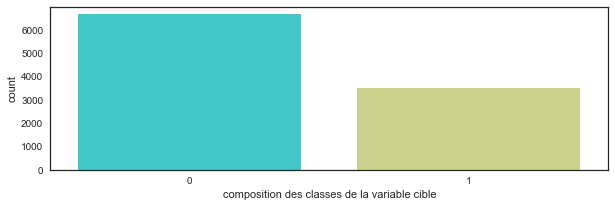

In [88]:
#Répartition des classes de la variable cible
plt.figure(figsize=(10,3))
sns.countplot(Y_train,palette='rainbow')
plt.xlabel('composition des classes de la variable cible')

Y_train.value_counts()

Mean: 0.345999
Std: 0.475716
Median: 0.000000
Skewness: 0.647578
Kurtosis: -1.580954


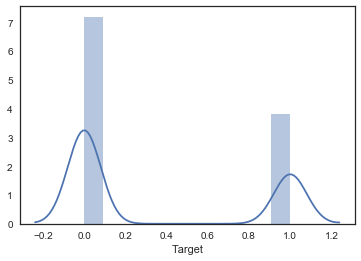

In [72]:
#Regardons la distribution de la variable cible
sns.distplot(Y_train);
plt.figure()
print("Mean: %f" % Y_train.mean())
print("Std: %f" % Y_train.std())
print("Median: %f" % Y_train.median())
print("Skewness: %f" % Y_train.skew())
print("Kurtosis: %f" % Y_train.kurt())

### Distrubution de l'ensemble des variables

KeyboardInterrupt: 

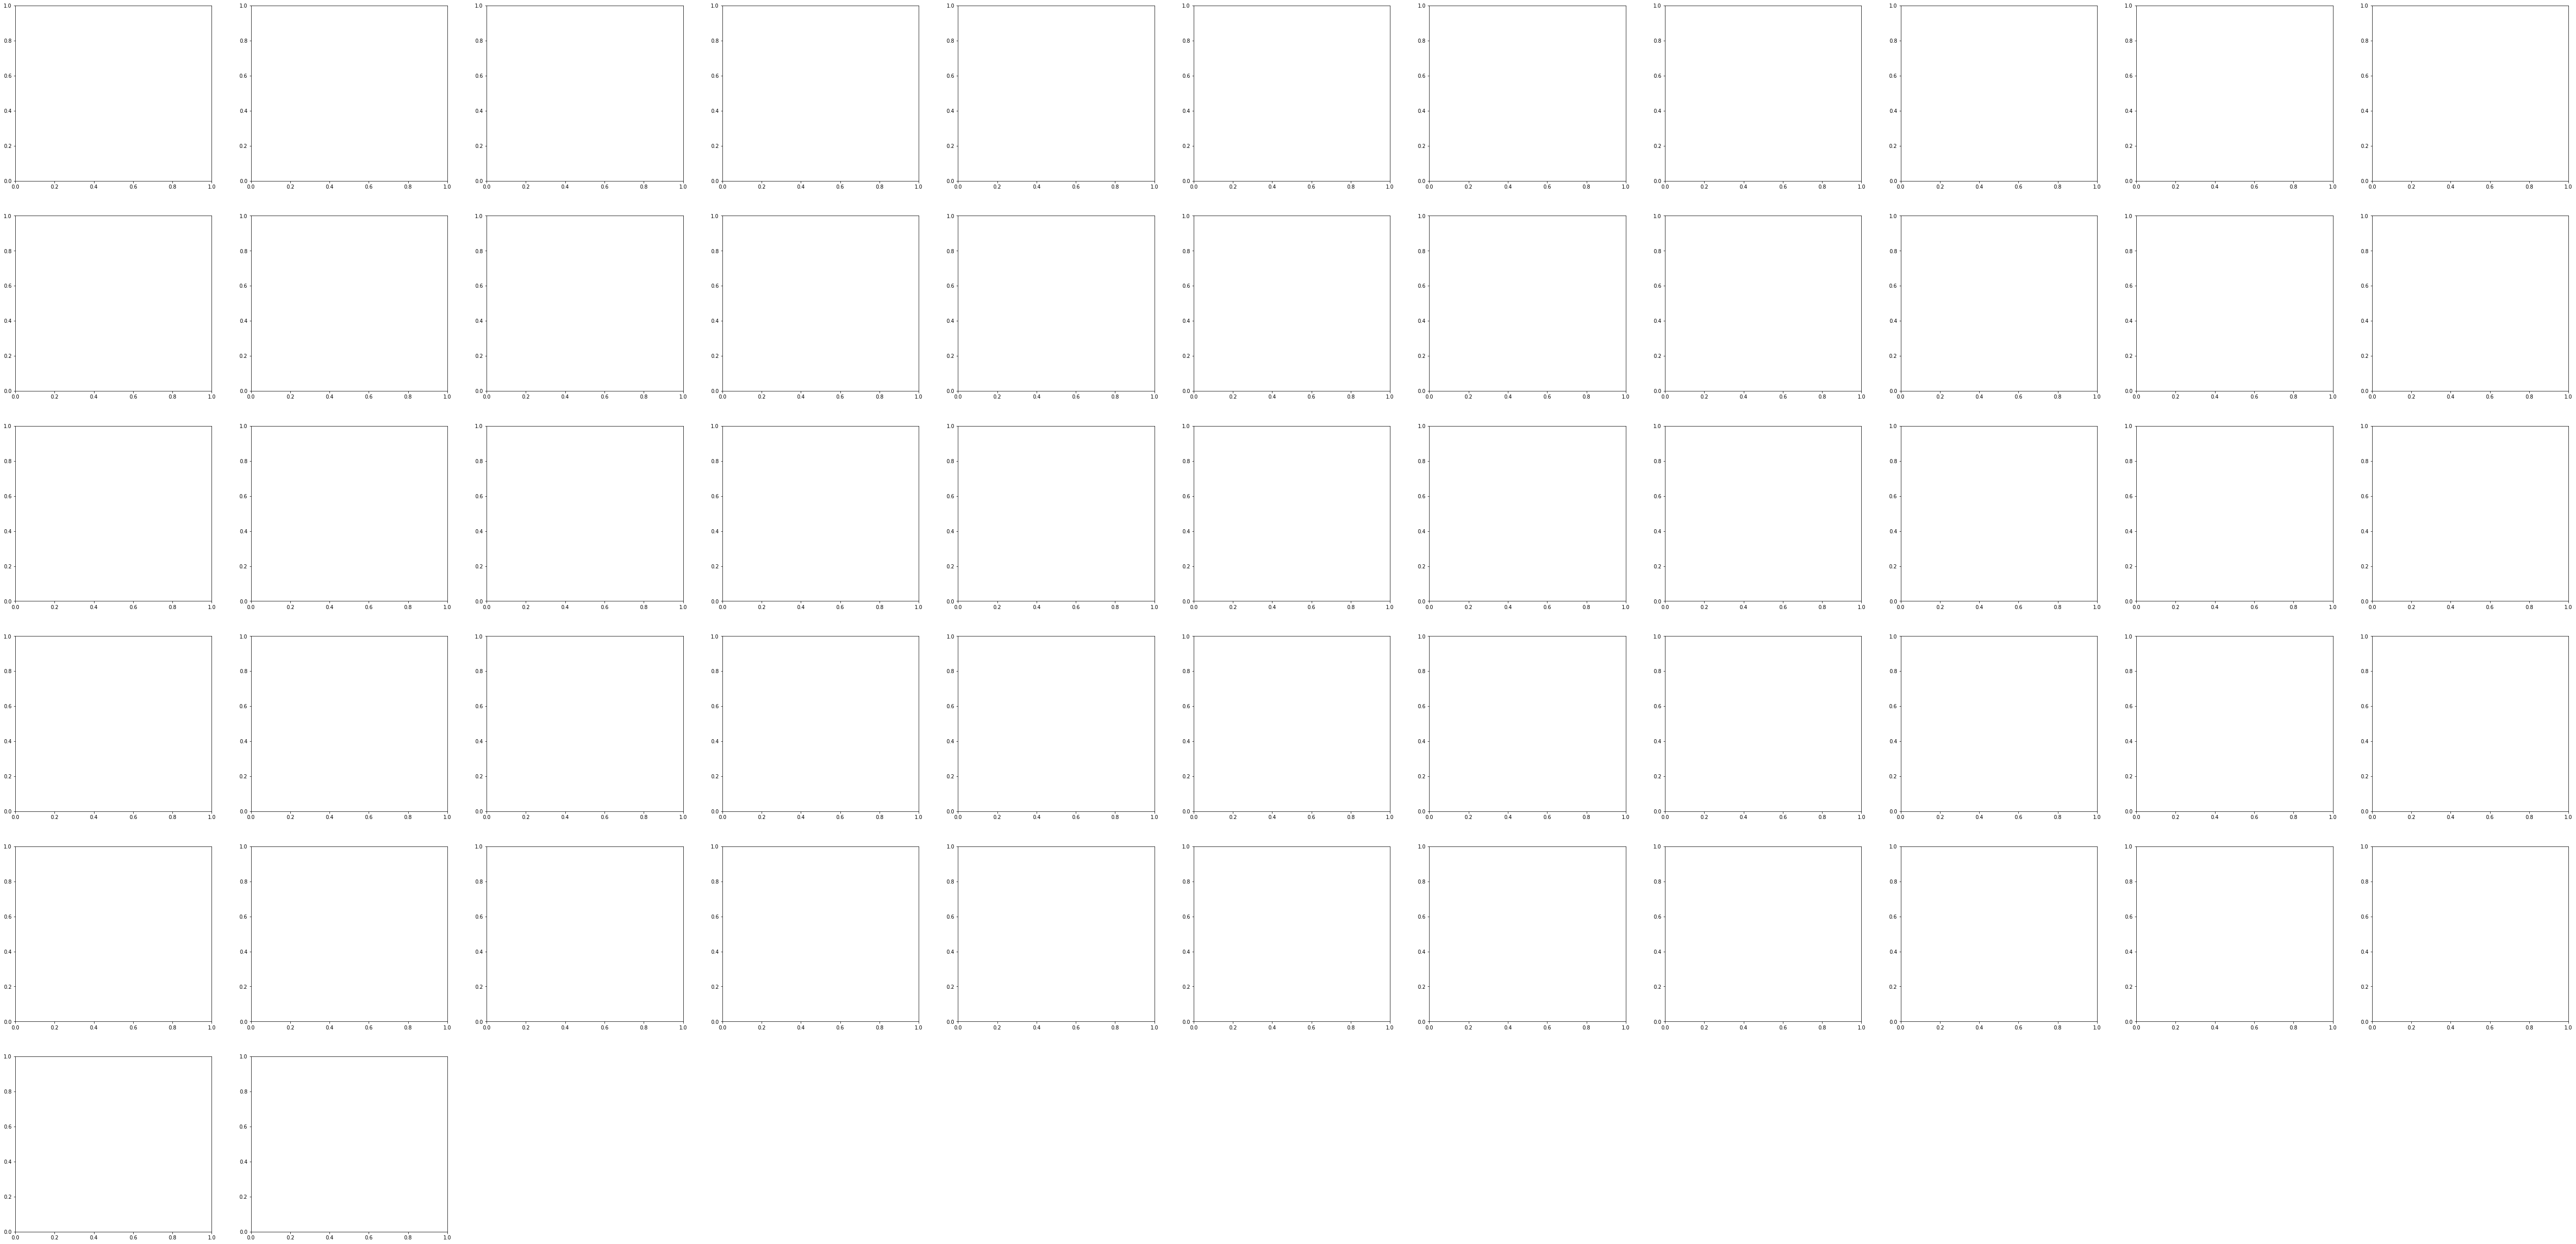

In [6]:
#Une façon de tout visualiser grâce à pandas
train.hist(figsize=(90, 90), bins=50);

### Variable catégorielle

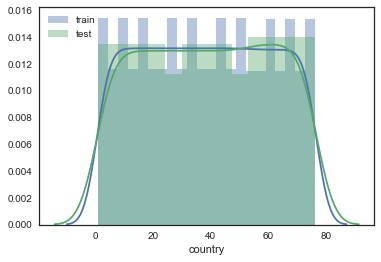

In [73]:
#On regarde les distributions des variables catégorielles mois et pays
sns.distplot(train['country'],label = 'train');
sns.distplot(test['country'], label = 'test');
plt.legend()

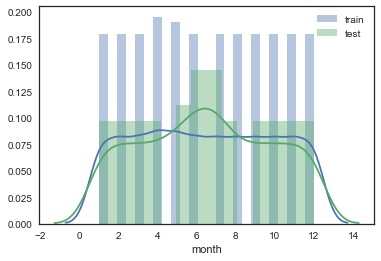

In [74]:
sns.distplot(train['month'],label = 'train');
sns.distplot(test['month'], label = 'test');
plt.legend()

### Impact des variables catégorielles sur la variable cible

In [89]:
# Ici nous allons définir un tableau de métadonnée qui contiendront les différents caractéristiques de nos données et leurs types
d = []
for f in train.columns:
    # Defining the role
    if f == 'Target':
        role = 'Target'
    elif f == 'Id':
        role = 'Id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'Target':
        level = 'binary'
    elif 'cat' in f or f == 'Id':
        level = 'nominal'
    elif train[f].dtype == 'float64':
        level = 'interval'
    elif train[f].dtype == 'int64':
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'Id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    d.append(f_dict)
    
meta = pd.DataFrame(d, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)
meta

,role,level,keep,dtype
varname,,,,
month,input,ordinal,True,int64
country,input,ordinal,True,int64
1_diffClosing stocks(kmt),input,interval,True,float64
1_diffExports(kmt),input,interval,True,float64
1_diffImports(kmt),input,interval,True,float64
1_diffRefinery intake(kmt),input,interval,True,float64
1_diffWTI,input,interval,True,float64
1_diffSumClosing stocks(kmt),input,interval,True,float64
1_diffSumExports(kmt),input,interval,True,float64


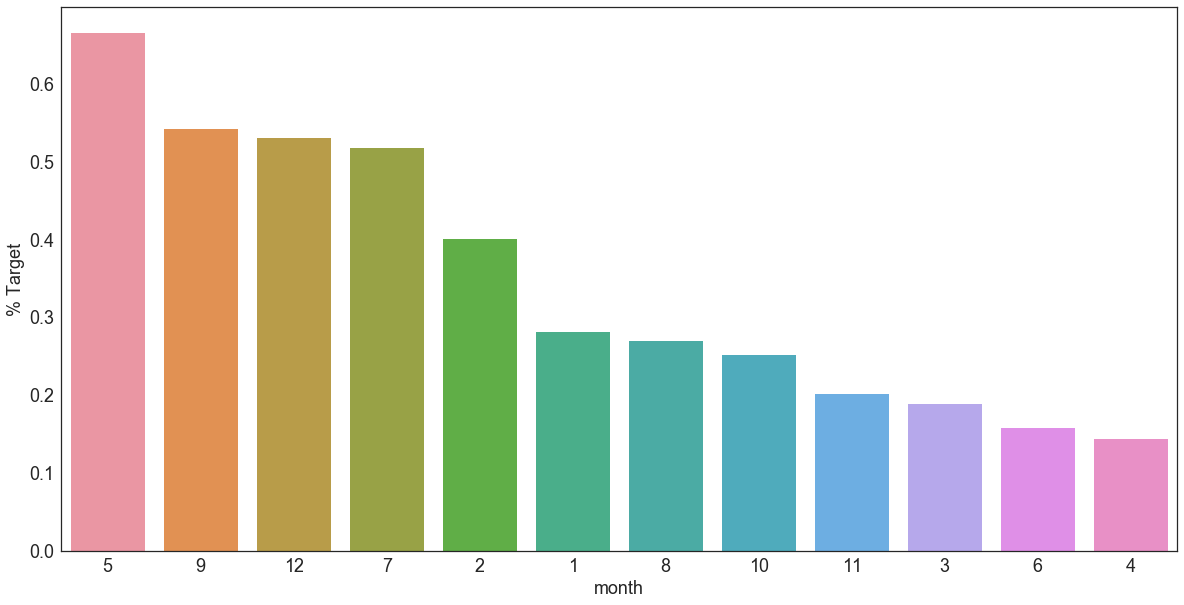

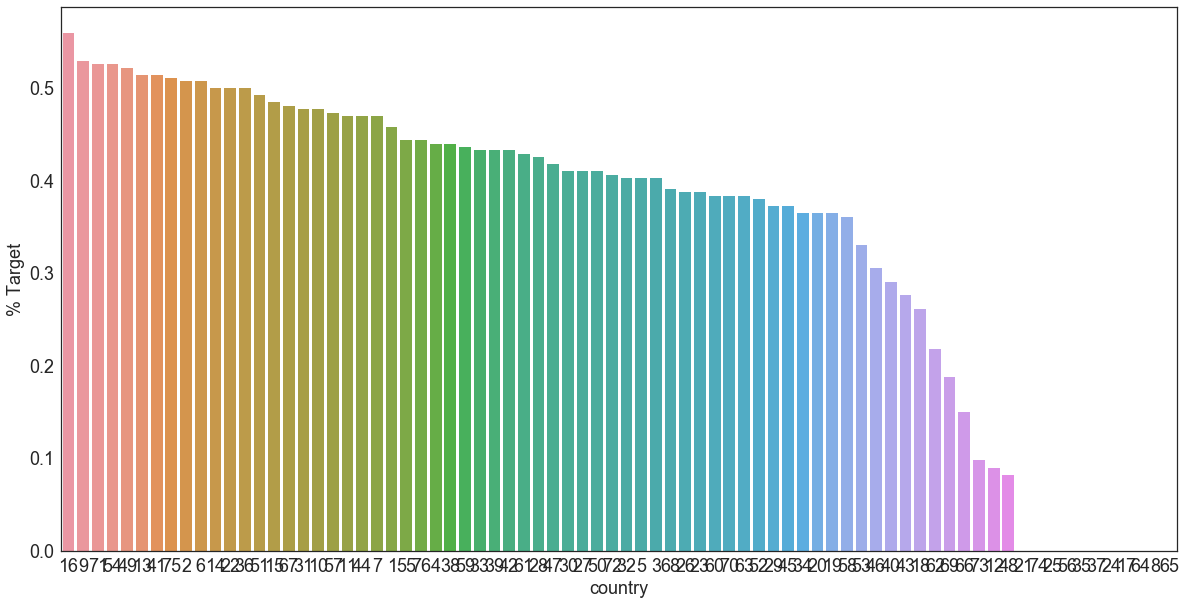

In [90]:
# d contient le tableau des variables catégorielles mois et pays
d = meta[(meta.level == 'ordinal') & (meta.keep)].index

for f in d:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calcul le pourcentage de la classe 1 (de la variable Target) pour chaque valeur des variables catégorielles
    cat_perc = train[[f, 'Target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='Target', ascending=False, inplace=True)
    # Bar plot
    # ordonne la barre dans l'ordre décroissant du pourcentage de la classe 1
    sns.barplot(ax=ax, x=f, y="Target", data=cat_perc, order=cat_perc[f])
    plt.ylabel("% Target", fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

### Traitement des valeurs manquantes

In [77]:
#Premierement les valeurs manquantes.

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent],axis=1,keys=["Total","Pourcentage"])
    
## affiche que les variables avec des na
    print(missing_data[(percent>0)],"\n")

print(Missing_values(train))
print(Missing_values(test))

                            Total  Pourcentage
1_diffClosing stocks(kmt)     261     0.025692
2_diffClosing stocks(kmt)     257     0.025298
3_diffClosing stocks(kmt)     253     0.024904
4_diffClosing stocks(kmt)     249     0.024510
5_diffClosing stocks(kmt)     245     0.024117
6_diffClosing stocks(kmt)     241     0.023723
7_diffClosing stocks(kmt)     238     0.023428
8_diffClosing stocks(kmt)     235     0.023132
9_diffClosing stocks(kmt)     232     0.022837
10_diffClosing stocks(kmt)    228     0.022443
11_diffClosing stocks(kmt)    224     0.022049
12_diffClosing stocks(kmt)    220     0.021656
1_diffImports(kmt)            151     0.014864
2_diffImports(kmt)            148     0.014568
3_diffImports(kmt)            145     0.014273
4_diffImports(kmt)            142     0.013978
5_diffImports(kmt)            139     0.013682
6_diffImports(kmt)            136     0.013387
7_diffImports(kmt)            133     0.013092
8_diffImports(kmt)            130     0.012797
9_diffImports

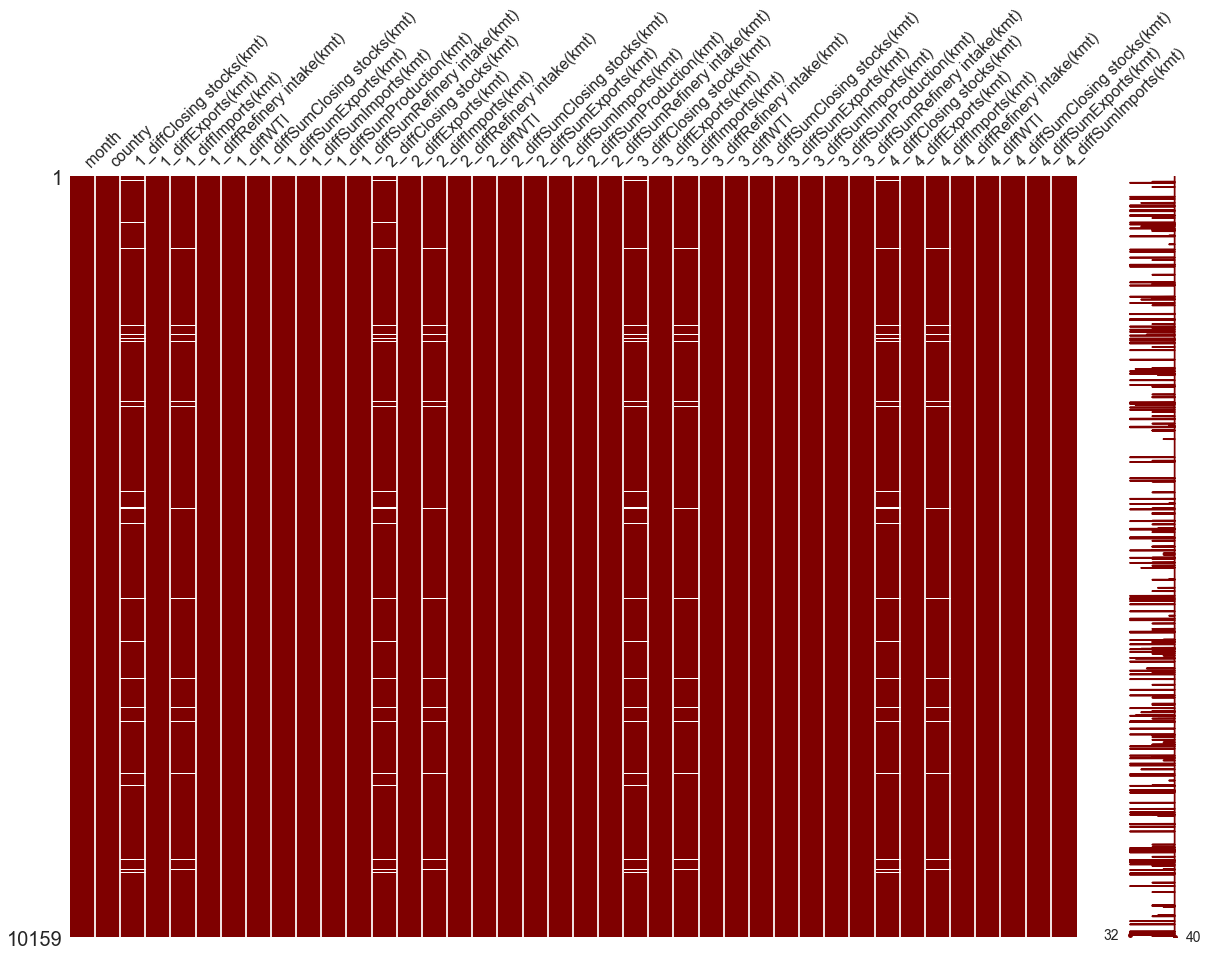

In [78]:
# autre manière d'observer les valeurs manquantes avec missingno
import missingno as msno
#Répartition des valeurs manquantes (traits blancs horizontales) sur les 40 premières variables de l’échantillon d’entraînements. 
msno.matrix(df=train.iloc[:,:40], figsize=(20,14), color=(0.5,0,0))

On regarde la distribution des variables concernées pour pouvoir adopter une stratégie.

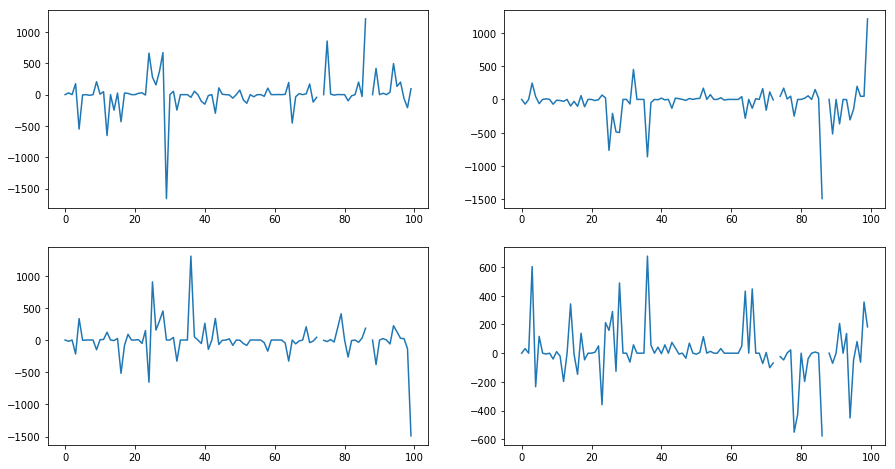

In [34]:
## on regarde la distribution des variables concernées

fig,axs = plt.subplots(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(train["1_diffClosing stocks(kmt)"].iloc[:100])
plt.subplot(2,2,2)
plt.plot(train["2_diffClosing stocks(kmt)"].iloc[:100])
plt.subplot(2,2,3)
plt.plot(train["3_diffClosing stocks(kmt)"].iloc[:100])
plt.subplot(2,2,4)
plt.plot(train["4_diffClosing stocks(kmt)"].iloc[:100])

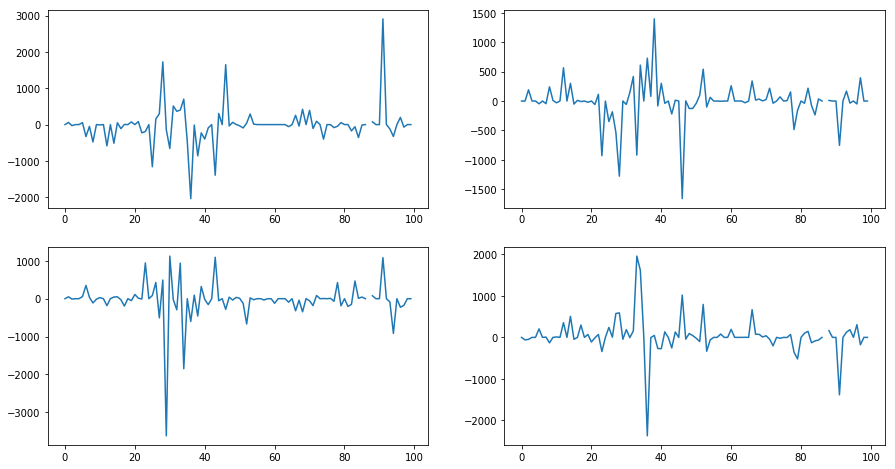

In [35]:
fig,axs = plt.subplots(figsize=(15,8))
plt.subplot(2,2,1)
plt.plot(train["1_diffImports(kmt)"].iloc[:100])
plt.subplot(2,2,2)
plt.plot(train["2_diffImports(kmt)"].iloc[:100])
plt.subplot(2,2,3)
plt.plot(train["3_diffImports(kmt)"].iloc[:100])
plt.subplot(2,2,4)
plt.plot(train["4_diffImports(kmt)"].iloc[:100])

Nous décidons de faire une interpollation quadratique.

In [106]:
train["1_diffClosing stocks(kmt)"] = train["1_diffClosing stocks(kmt)"].interpolate('quadratic')
train["2_diffClosing stocks(kmt)"] = train["2_diffClosing stocks(kmt)"].interpolate('quadratic')
train["3_diffClosing stocks(kmt)"] = train["3_diffClosing stocks(kmt)"].interpolate('quadratic')
train["4_diffClosing stocks(kmt)"] = train["4_diffClosing stocks(kmt)"].interpolate('quadratic')
train["5_diffClosing stocks(kmt)"] = train["5_diffClosing stocks(kmt)"].interpolate('quadratic')
train["6_diffClosing stocks(kmt)"] = train["6_diffClosing stocks(kmt)"].interpolate('quadratic')
train["7_diffClosing stocks(kmt)"] = train["7_diffClosing stocks(kmt)"].interpolate('quadratic')
train["8_diffClosing stocks(kmt)"] = train["8_diffClosing stocks(kmt)"].interpolate('quadratic')
train["9_diffClosing stocks(kmt)"] = train["9_diffClosing stocks(kmt)"].interpolate('quadratic')
train["10_diffClosing stocks(kmt)"] = train["10_diffClosing stocks(kmt)"].interpolate('quadratic')
train["11_diffClosing stocks(kmt)"] = train["11_diffClosing stocks(kmt)"].interpolate('quadratic')
train["12_diffClosing stocks(kmt)"] = train["12_diffClosing stocks(kmt)"].interpolate('quadratic')

train["1_diffImports(kmt)"] = train["1_diffImports(kmt)"].interpolate('quadratic')
train["2_diffImports(kmt)"] = train["2_diffImports(kmt)"].interpolate('quadratic')
train["3_diffImports(kmt)"] = train["3_diffImports(kmt)"].interpolate('quadratic')
train["4_diffImports(kmt)"] = train["4_diffImports(kmt)"].interpolate('quadratic')
train["5_diffImports(kmt)"] = train["5_diffImports(kmt)"].interpolate('quadratic')
train["6_diffImports(kmt)"] = train["6_diffImports(kmt)"].interpolate('quadratic')
train["7_diffImports(kmt)"] = train["7_diffImports(kmt)"].interpolate('quadratic')
train["8_diffImports(kmt)"] = train["8_diffImports(kmt)"].interpolate('quadratic')
train["9_diffImports(kmt)"] = train["9_diffImports(kmt)"].interpolate('quadratic')
train["10_diffImports(kmt)"] = train["10_diffImports(kmt)"].interpolate('quadratic')
train["11_diffImports(kmt)"] = train["11_diffImports(kmt)"].interpolate('quadratic')
train["12_diffImports(kmt)"] = train["12_diffImports(kmt)"].interpolate('quadratic')

## Corrélation

Afin de visualiser la corrélation entre les variables, on observe la matrice de corrélation.

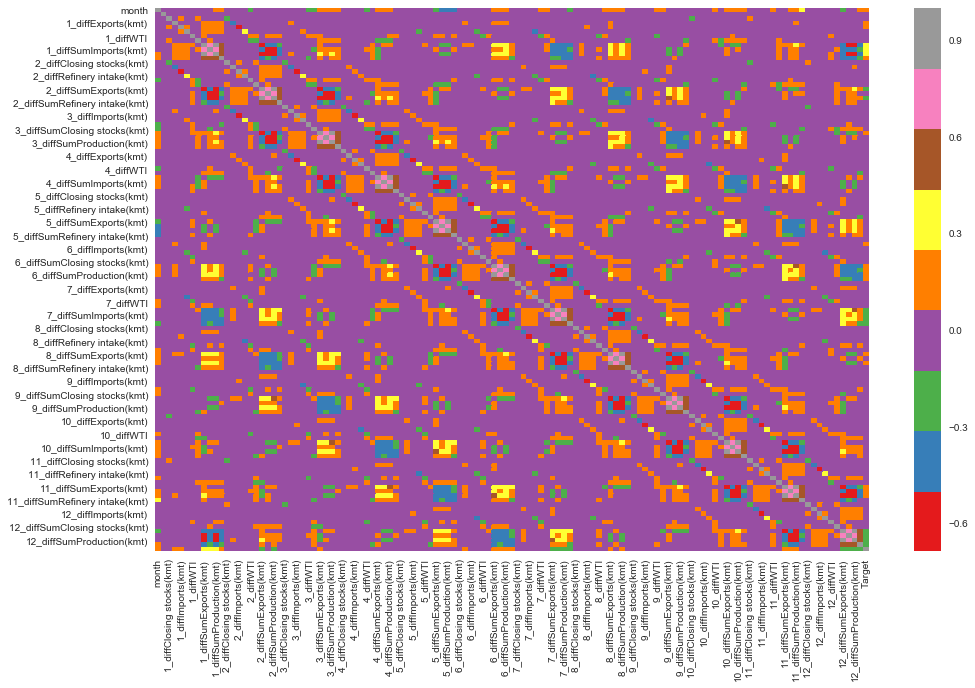

In [107]:
# matrice de corrélation
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor,cmap='Set1')

## selection variables

### Par l'algorithme RFE

Training done using Random Forest


C:\Users\achir_zgtpmg8\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


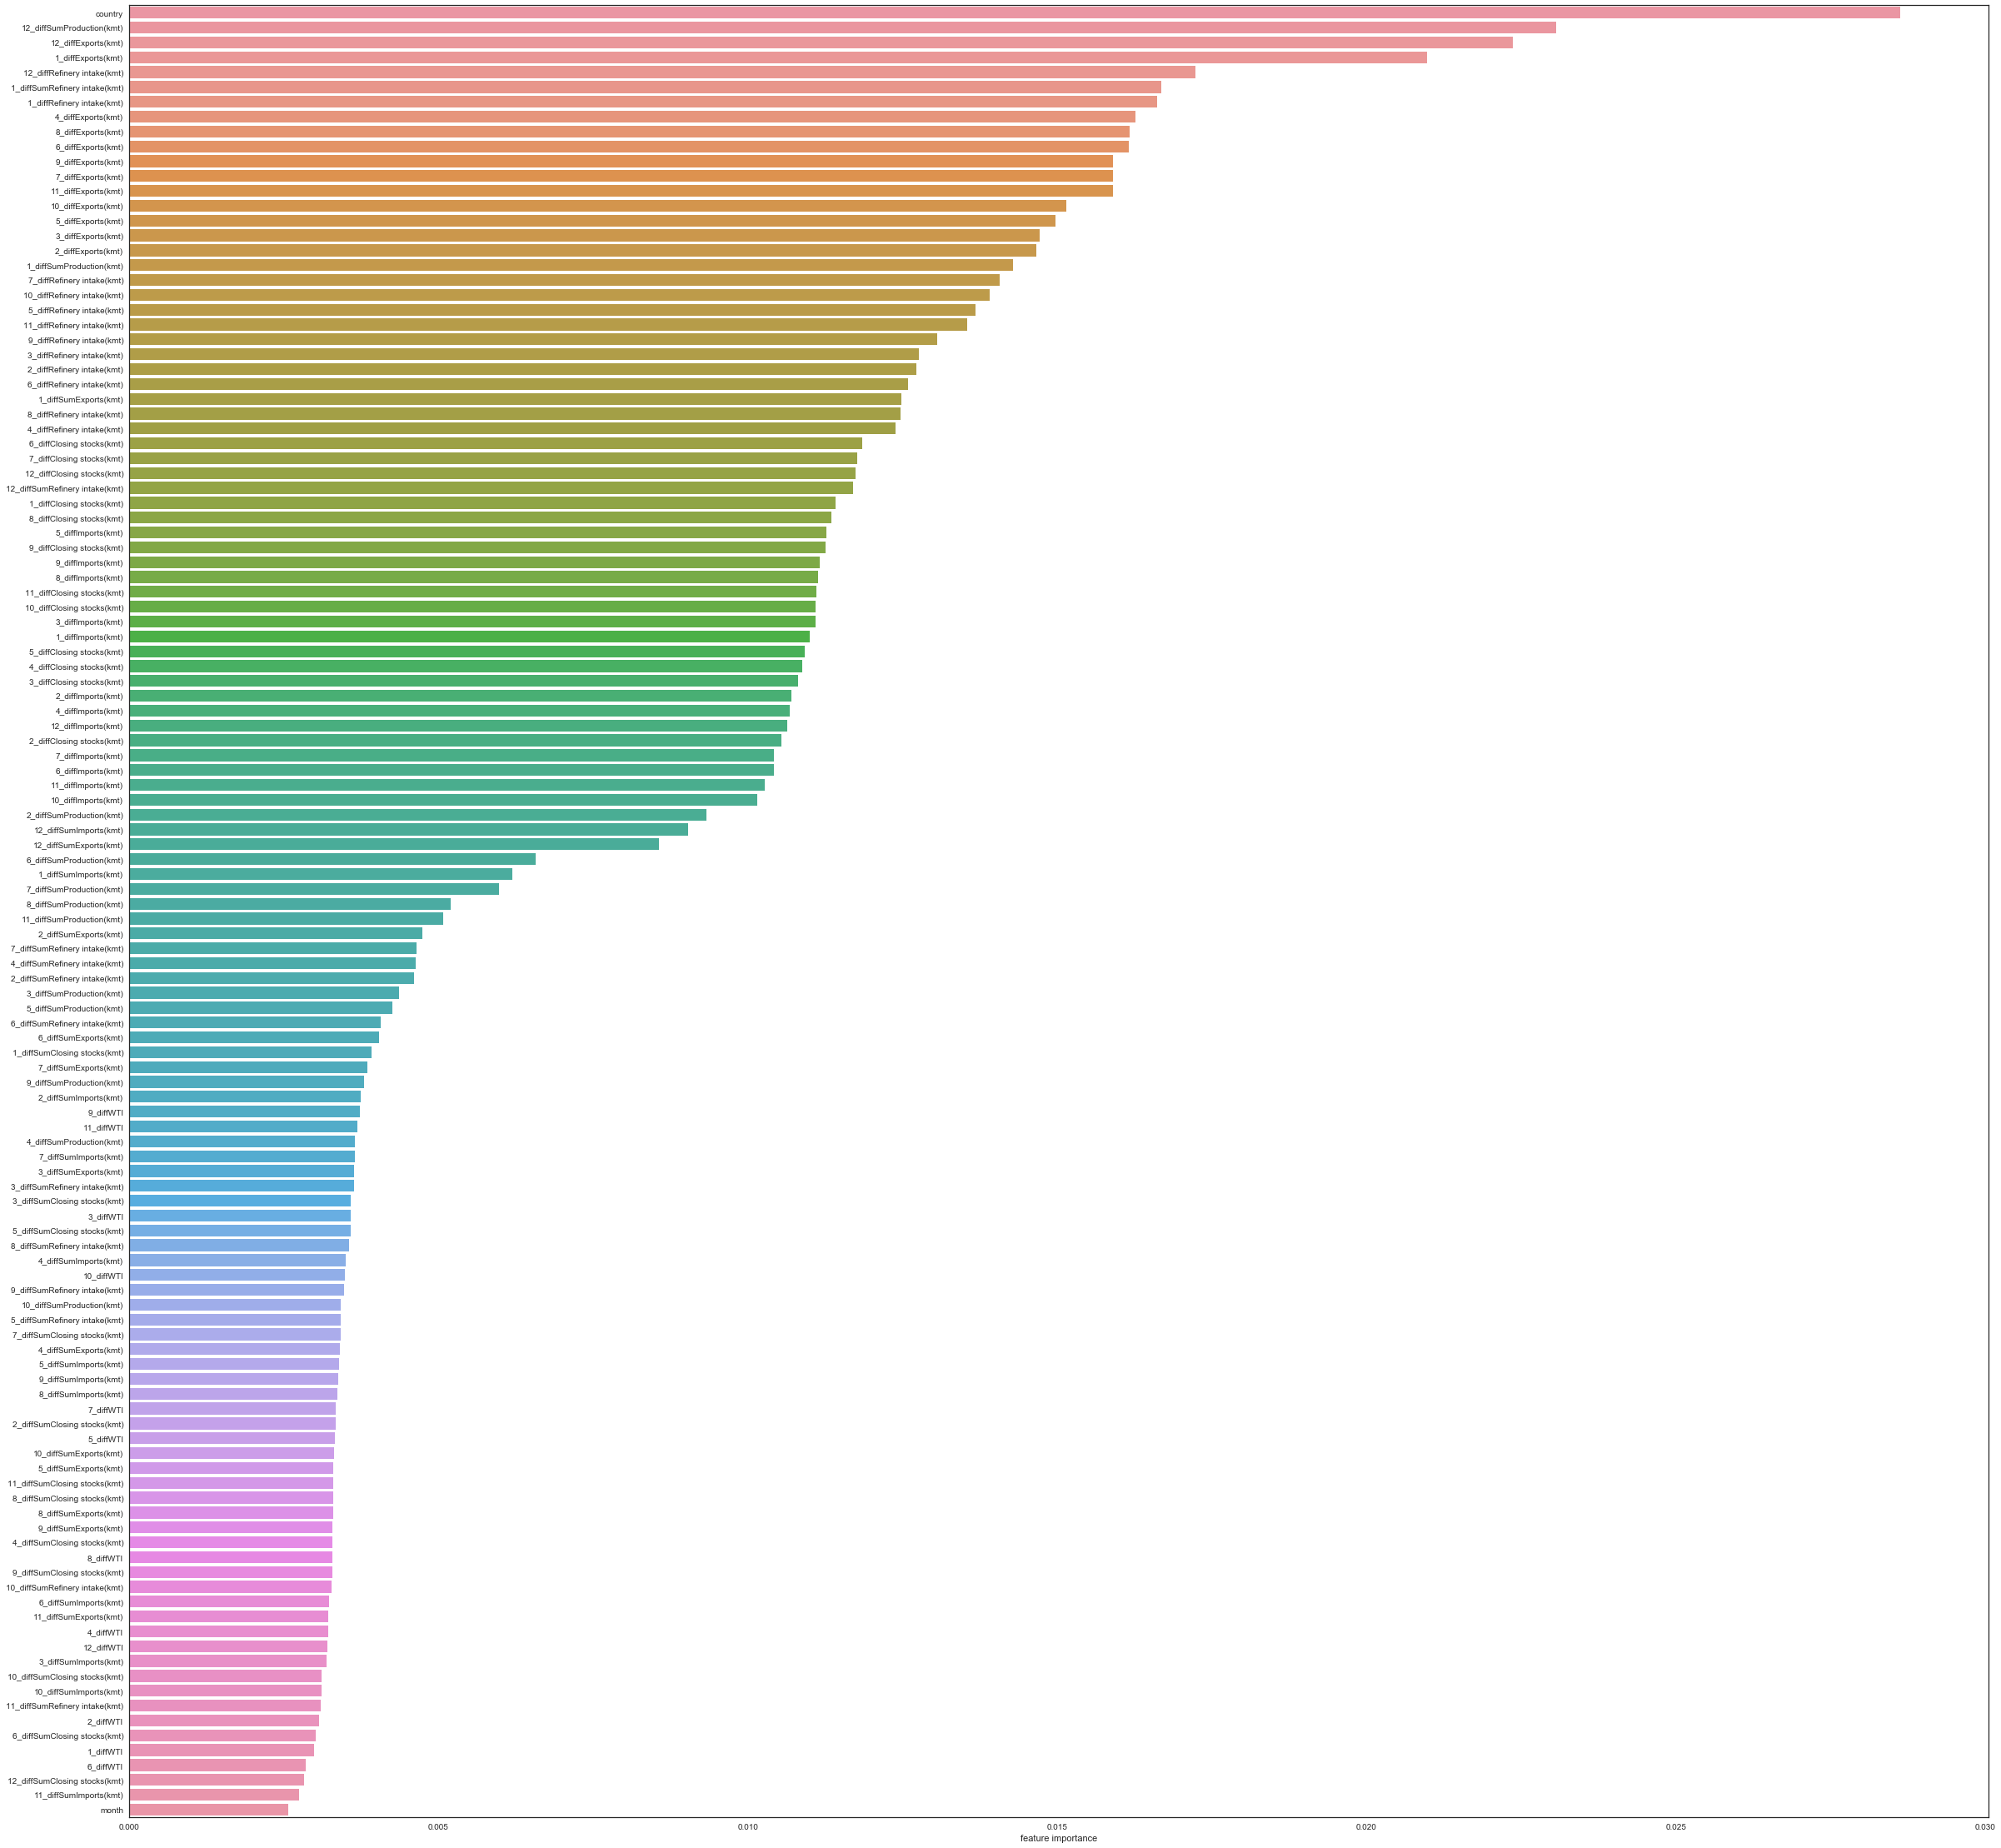

In [108]:
train_RFE = pd.concat([train,Y_train],axis=1)

# Selection de variable par l'algorithme de forêt aléatoire
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt')
rf.fit(train.loc[:, train_RFE.columns != 'Target'],train_RFE['Target'])

print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(40, 40))
sns.barplot(x=rf.feature_importances_[ranking], y=train_RFE.ix[:, train_RFE.columns != 'Target'].columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.show()
        

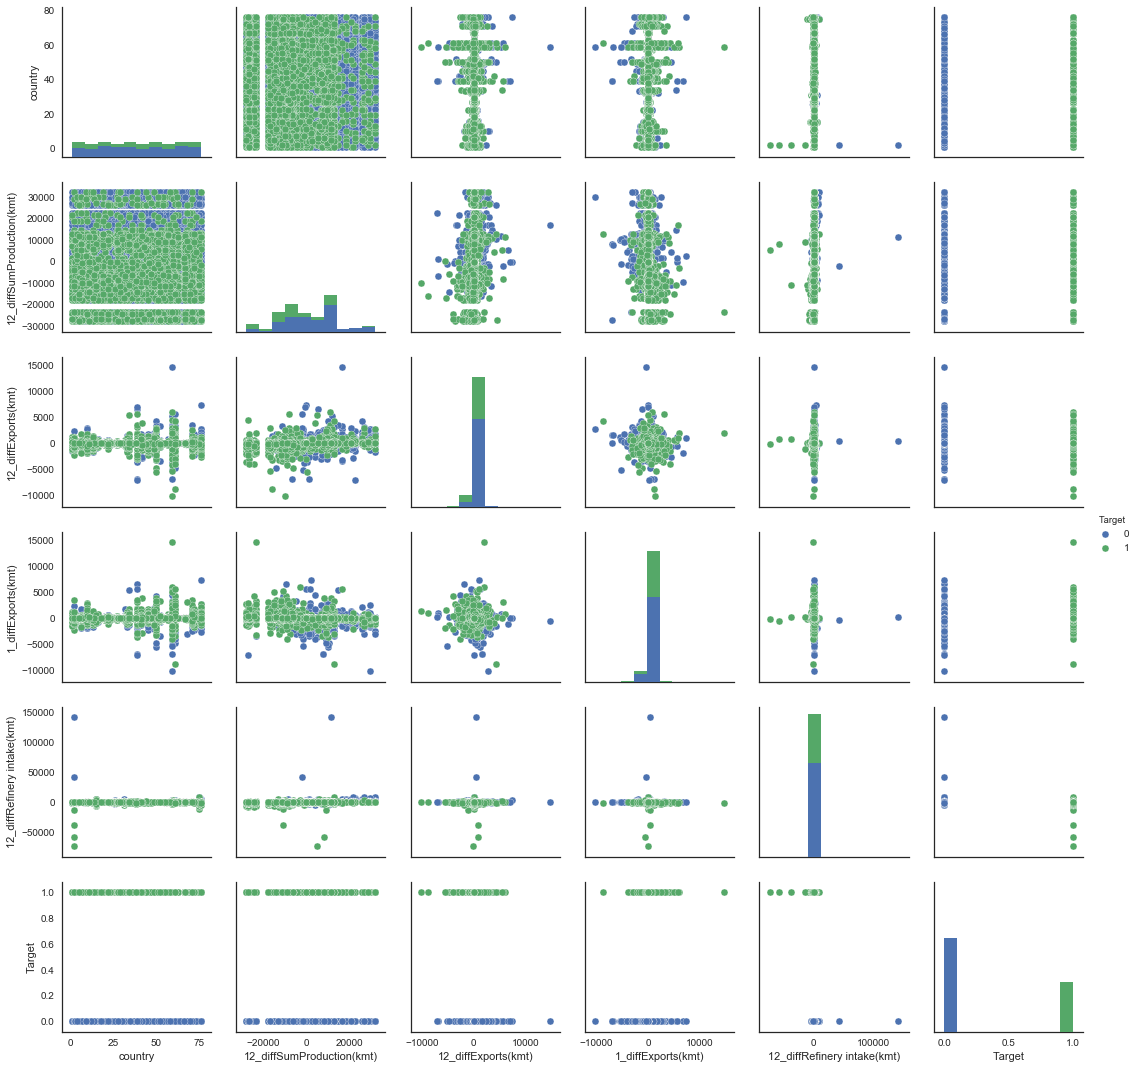

In [109]:
# Les 5 premières variables importantes pour la prédiction du Target selon l’algorithme RFE 
Train=pd.concat([train.iloc[:,ranking[:5]],Y_train],axis=1)
ax = sns.pairplot(Train, hue='Target')
plt.show()

Nous voyons une séparation entre les deux classes 0 et 1 de la variables Target.

### En utilisant une ACP 

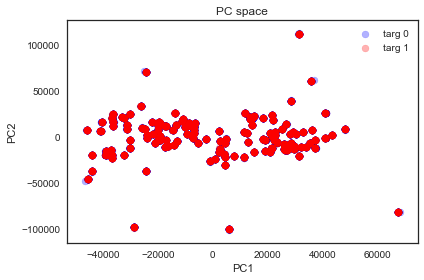

PCA done


In [110]:
# PCA
Xdr = train
target=Xdr['Target']
Xdr1 = Xdr.loc[target==1, :]
Xdr0 = Xdr.loc[target==0, :]
Xdr = Xdr.drop(['Target'], axis=1)

from sklearn.decomposition import PCA

pcamat = PCA(n_components=2).fit_transform(Train_pca)

plt.figure()
plt.scatter(pcamat[:Xdr0.shape[0],0],pcamat[:Xdr0.shape[0],1], c='b', label='targ 0', alpha=0.3)
plt.scatter(pcamat[Xdr0.shape[0]:,0],pcamat[Xdr0.shape[0]:,1],c='r', label='targ 1', alpha=0.3)
plt.legend()
plt.title('PC space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()
print("PCA done")

### Prétraîtement de la matrice de corrélation

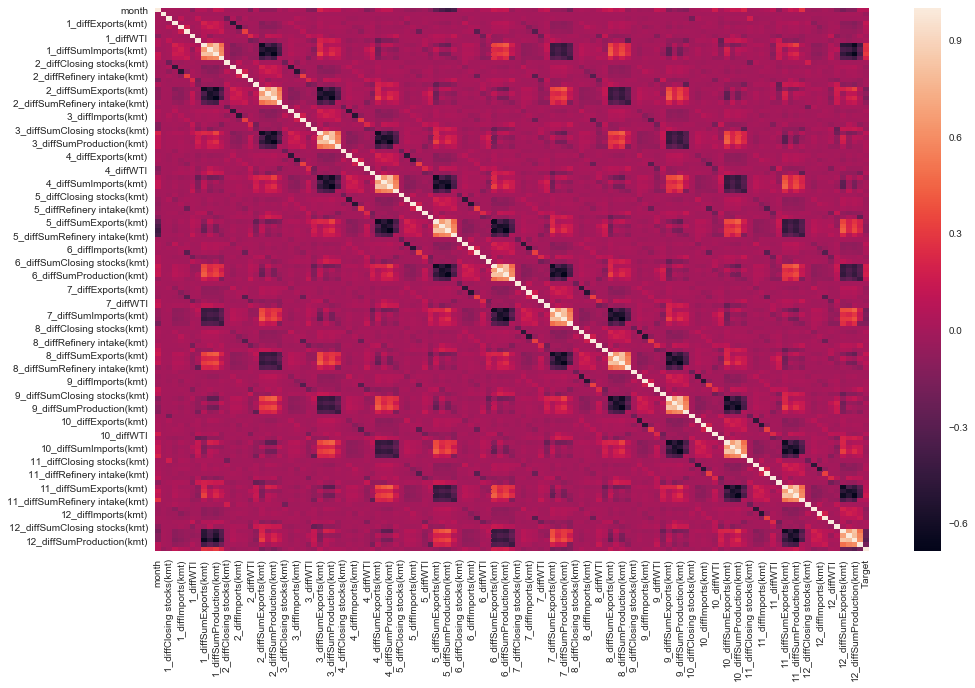

In [111]:
# corrélation avec l'ensemble des variables
import seaborn as sns
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

En effet comme vous pouvez le constater, il est difficile de determiner la corrélation entre chacune des variables nous avons utilisé la fonction ci-dessous afin de faire une selection de variables.

In [112]:
## pour les corrélations négatives 

def corr_df_neg(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if val <= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        df = x.drop(col, axis=1)

    return df

In [113]:
train.drop(['1_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['2_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['3_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['5_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['7_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['9_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['11_diffSumImports(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffSumImports(kmt)'], axis = 1, inplace = True)

train.drop(['1_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['2_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['3_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['5_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['7_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['9_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['11_diffSumExports(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffSumExports(kmt)'], axis = 1, inplace = True)


train.drop(['2_diffSumProduction(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffSumProduction(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffSumProduction(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffSumProduction(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffSumProduction(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffSumProduction(kmt)'], axis = 1, inplace = True)

train.drop(['2_diffImports(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffImports(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffImports(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffImports(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffImports(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffImports(kmt)'], axis = 1, inplace = True)

train.drop(['1_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['3_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['5_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['7_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['9_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['11_diffClosing stocks(kmt)'], axis = 1, inplace = True)

train.drop(['2_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffClosing stocks(kmt)'], axis = 1, inplace = True)

train.drop(['1_diffWTI'], axis = 1, inplace = True)
train.drop(['2_diffWTI'], axis = 1, inplace = True)
train.drop(['3_diffWTI'], axis = 1, inplace = True)
train.drop(['4_diffWTI'], axis = 1, inplace = True)
train.drop(['5_diffWTI'], axis = 1, inplace = True)
train.drop(['6_diffWTI'], axis = 1, inplace = True)
train.drop(['7_diffWTI'], axis = 1, inplace = True)
train.drop(['8_diffWTI'], axis = 1, inplace = True)
train.drop(['9_diffWTI'], axis = 1, inplace = True)
train.drop(['10_diffWTI'], axis = 1, inplace = True)
train.drop(['11_diffWTI'], axis = 1, inplace = True)
train.drop(['12_diffWTI'], axis = 1, inplace = True)

train.drop(['1_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['2_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['3_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['5_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['7_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['9_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['11_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)

train.drop(['1_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['2_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['3_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['5_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['7_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['9_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['11_diffRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffRefinery intake(kmt)'], axis = 1, inplace = True)

train.drop(['1_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['2_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['3_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['4_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['5_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['6_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['7_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['8_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['9_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['10_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['11_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
train.drop(['12_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)

Nous allons donc supprimer les variables trop corrélées ou ayant peu d'importance pour la prédiction de la variable cible

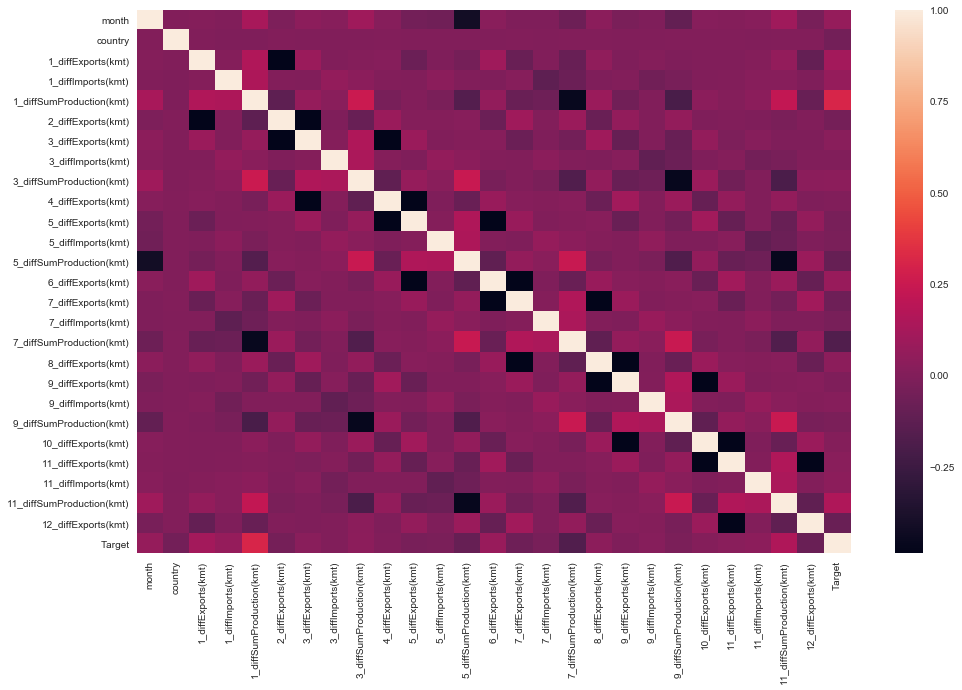

In [114]:
# matrice de corrélation après séléction de variables
import seaborn as sns
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

In [115]:
## pareil pour le test


test.drop(['1_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['2_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['3_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['5_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['7_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['9_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['11_diffSumImports(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffSumImports(kmt)'], axis = 1, inplace = True)

test.drop(['1_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['2_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['3_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['5_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['7_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['9_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['11_diffSumExports(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffSumExports(kmt)'], axis = 1, inplace = True)

test.drop(['2_diffImports(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffImports(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffImports(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffImports(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffImports(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffImports(kmt)'], axis = 1, inplace = True)

test.drop(['2_diffSumProduction(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffSumProduction(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffSumProduction(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffSumProduction(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffSumProduction(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffSumProduction(kmt)'], axis = 1, inplace = True)

test.drop(['1_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['2_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['3_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['5_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['7_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['9_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['11_diffClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffClosing stocks(kmt)'], axis = 1, inplace = True)

test.drop(['1_diffWTI'], axis = 1, inplace = True)
test.drop(['2_diffWTI'], axis = 1, inplace = True)
test.drop(['3_diffWTI'], axis = 1, inplace = True)
test.drop(['4_diffWTI'], axis = 1, inplace = True)
test.drop(['5_diffWTI'], axis = 1, inplace = True)
test.drop(['6_diffWTI'], axis = 1, inplace = True)
test.drop(['7_diffWTI'], axis = 1, inplace = True)
test.drop(['8_diffWTI'], axis = 1, inplace = True)
test.drop(['9_diffWTI'], axis = 1, inplace = True)
test.drop(['10_diffWTI'], axis = 1, inplace = True)
test.drop(['11_diffWTI'], axis = 1, inplace = True)
test.drop(['12_diffWTI'], axis = 1, inplace = True)


test.drop(['1_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['2_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['3_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['5_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['7_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['9_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['11_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffSumClosing stocks(kmt)'], axis = 1, inplace = True)

test.drop(['1_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['2_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['3_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['5_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['7_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['9_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['11_diffRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffRefinery intake(kmt)'], axis = 1, inplace = True)

test.drop(['1_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['2_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['3_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['4_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['5_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['6_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['7_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['8_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['9_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['10_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['11_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)
test.drop(['12_diffSumRefinery intake(kmt)'], axis = 1, inplace = True)

### Binarisation des variables catégorielles

In [116]:
train = pd.get_dummies(train,columns = ['month','country'])
test = pd.get_dummies(test,columns = ['month','country'])

Nous stockons la variable "ID" car nous en aurons besoin un peu plus tard.

In [346]:
identifiant = test["ID"]
test.drop(['ID'], axis = 1, inplace = True)

# B - Algorithme

Nous faisons ici un split de nos données.

In [117]:
from sklearn.cross_validation import train_test_split
train.drop(['Target'], axis = 1, inplace = True)

X_train,X_test,y_train,y_test = train_test_split(train,Y_train, random_state =1234 , test_size = 0.33) 


C:\Users\achir_zgtpmg8\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [128]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# All classifiers with default parameters
clfs = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LogisticRegression()
]

aucs = []
fprs = []
tprs = []
precisions = []
recalls = []
f1_scores = []

for clf in clfs:
    print(clf.__class__.__name__)
    clf.fit(X_train, y_train)

    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])    
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score(y_test, clf.predict(X_test)))

RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
LGBMClassifier


C:\Users\achir_zgtpmg8\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\achir_zgtpmg8\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


DecisionTreeClassifier
ExtraTreeClassifier
LogisticRegression


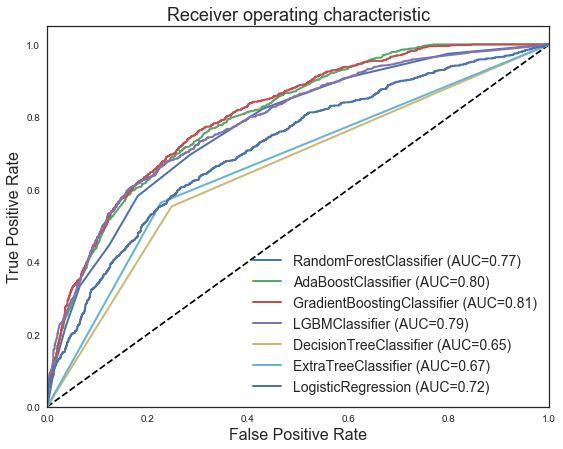

In [129]:
names = [clf.__class__.__name__ for clf in clfs]

plt.figure(figsize=(9, 7))
plt.plot([0, 1], [0, 1], 'k--')

for fpr, tpr, auc, name in zip(fprs, tprs, aucs, names):
    plt.plot(fpr, tpr, label=name + ' (AUC=%.2f)' % auc, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right", fontsize=14)

Nous avons choisi le Gradiant Boosting.

Maintenant, nous procédons à l'étape de la GridSearch

In [124]:
## gradient boosting

from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import randint, uniform




model = GradientBoostingClassifier(loss="exponential")

param_dist = {"max_depth": sp_randint(1, 11),
              'n_estimators' : sp_randint(100, 300),
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11)}

grid_rand = RandomizedSearchCV(model, param_distributions=param_dist,cv=3,scoring = 'roc_auc',n_jobs=-1,verbose = 1,n_iter=20)
grid_rand.fit(X_train,y_train)

C:\Users\achir_zgtpmg8\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025C0FCA6940>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025C10272550>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025C1B306588>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025C0F6DD978>, '

In [132]:
print ('Résultat de la grid search :', grid_rand.best_score_, grid_rand.best_params_)

from sklearn.metrics import roc_auc_score,roc_curve,auc

##On peut récupérer le meilleur modèle : 
best = grid_rand.best_estimator_

print ('Performance du modèle optimisé :', roc_auc_score(y_test,best.predict_proba(X_test)[:,1]))


Résultat de la grid search : 0.8162852029930873 {'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 247}
Performance du modèle optimisé : 0.815575958884


In [130]:
# Pour sauvegarder le modèle et ne plus recompiler
import pickle
with open('model.pkl', 'wb') as output:
    pickle.dump(grid_rand, output, pickle.HIGHEST_PROTOCOL)
    output.close()

In [131]:
# Sauvegarde du modèle 
import pickle
with open('model.pkl', 'rb') as input_file:
    grid_rand = pickle.load(input_file)
    input_file.close()

On fait la même chose mais cette fois ci avec l'intégralité de nos données.

In [352]:


## gradient boosting

from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import randint, uniform




model = GradientBoostingClassifier(loss="exponential")

param_dist = {"max_depth": sp_randint(1, 11),
              'n_estimators' : sp_randint(100, 300),
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11)}

grid_rand = RandomizedSearchCV(model, param_distributions=param_dist,cv=3,scoring = 'roc_auc',n_jobs=-1,verbose = 1,n_iter=700)
grid_rand.fit(train,Y_train)

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed: 17.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params={}, iid=True, n_iter=700, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D314AE9208>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D314AE9630>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D314AE9A20>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D312C41358>, 

In [ ]:
# Pour sauvegarder le modèle et ne plus recompiler
import pickle
with open('model.pkl', 'wb') as output:
    pickle.dump(grid_rand, output, pickle.HIGHEST_PROTOCOL)
    output.close()

In [ ]:
# Sauvegarde du modèle 
import pickle
with open('model.pkl', 'rb') as input_file:
    grid_rand = pickle.load(input_file)
    input_file.close()

In [353]:
best = grid_rand.best_estimator_
best.predict_proba(test)[:,1]

array([ 0.11070324,  0.04879903,  0.90165868, ...,  0.0475929 ,
        0.3446446 ,  0.57250433])

In [354]:
df = pd.DataFrame(data= best.predict_proba(test)[:,1], columns=["Target"])
df.to_csv('proba.csv', sep = ';')

Nous passons enfin à la dernière étape c'est à dire celle de la combinaison de nos données.
Nous simulons plusieurs Gradiant Boosting et nous faisons une intersection ce qui nous permet d'avoir une certaine stabilité.

In [ ]:
## maintenant pour les n simulations

from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import randint, uniform
liste = []

for i in np.arange(200):
    
    model = GradientBoostingClassifier(loss="exponential")

    param_dist = {"max_depth": sp_randint(1, 11),
              'n_estimators' : sp_randint(100, 300),
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11)}

    grid_rand = RandomizedSearchCV(model, param_distributions=param_dist,cv=3,scoring = 'roc_auc',n_jobs=-1,verbose = 1,n_iter=100)
    grid_rand.fit(train,Y_train)
    best = grid_rand.best_estimator_
    liste.append(best.predict_proba(test)[:,1])
    

def matrix (liste):
    return (pd.DataFrame(liste, columns= identifiant))

matrice = matrix(liste)
matrice.to_csv("200_simulations.csv",sep=";")
proba_moyenne = np.array(matrice.describe().loc["mean"])
df = pd.DataFrame(data= proba_moyenne, columns=["Target"])
df.to_csv('proba_moyenne_n_200.csv', sep = ';')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [369]:
df

,Target
0,0.110703
1,0.048799
2,0.901659
3,0.727063
4,0.386023
5,0.128138
6,0.456704
7,0.228784
8,0.296597
9,0.067871
